In [8]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Modelos con polinomios autoregresivos

* Modelo ARX
* Modelo ARMAX


Dada una señal de entrada y salida (archivo class_09.csv), obtenga el modelo estimado usando el modelo ARMAX.

**Paso 1: Lectura de los datos**

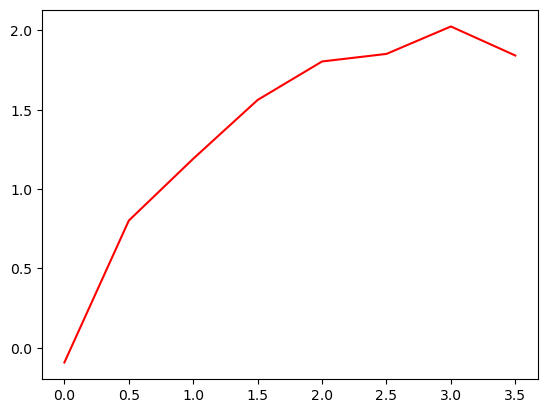

In [9]:
datos = pd.read_csv ('data\exercise_05.csv')
t = datos.t
yn = datos.yn
N = len(t)
u = datos.un
plt.plot(t,yn,color = 'red')
dt = (t[1] - t[0])
dt

## Definiendo la matriz de regresión

**Paso 2:** Proponer el regresor de la estimación ARX y calcular los parámetros $\theta$ de la estimación ARX, para este ejemplo se propone:

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1]]$$

In [12]:
## Definir y_1, y_2, dependiendo el sistema que se quiera modelar, 
## así como u_1, u_2 y las que se requieran

y_1 = np.zeros(N)
y_2 = np.zeros(N)
y_3 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
u_3 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
for k in range(3,N):
    y_3[k]=yn[k-3]
    u_3[k]=u[k-3]

## Creación del vector phi
phi = np.array([-y_1,u_1]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 1e-2
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.57159685,  0.8348667 ])

In [13]:
t_est = 1
dfReg = pd.DataFrame(data={'t':t,'y':yn,'y_1':y_1,'y_2':y_2,'y_3':y_3,'u_1':u_1,'u_2':u_2,'u_3':u_3})
dfReg['Estable'] = np.where(dfReg['t'] >= t_est,'Estable','Transitorio')

C:\Users\Jairo_PC\AppData\Local\Temp\ipykernel_10020\3850028227.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  append(dfReg[dfReg['Estable'] == 'Transitorio'])).reset_index(drop=True)


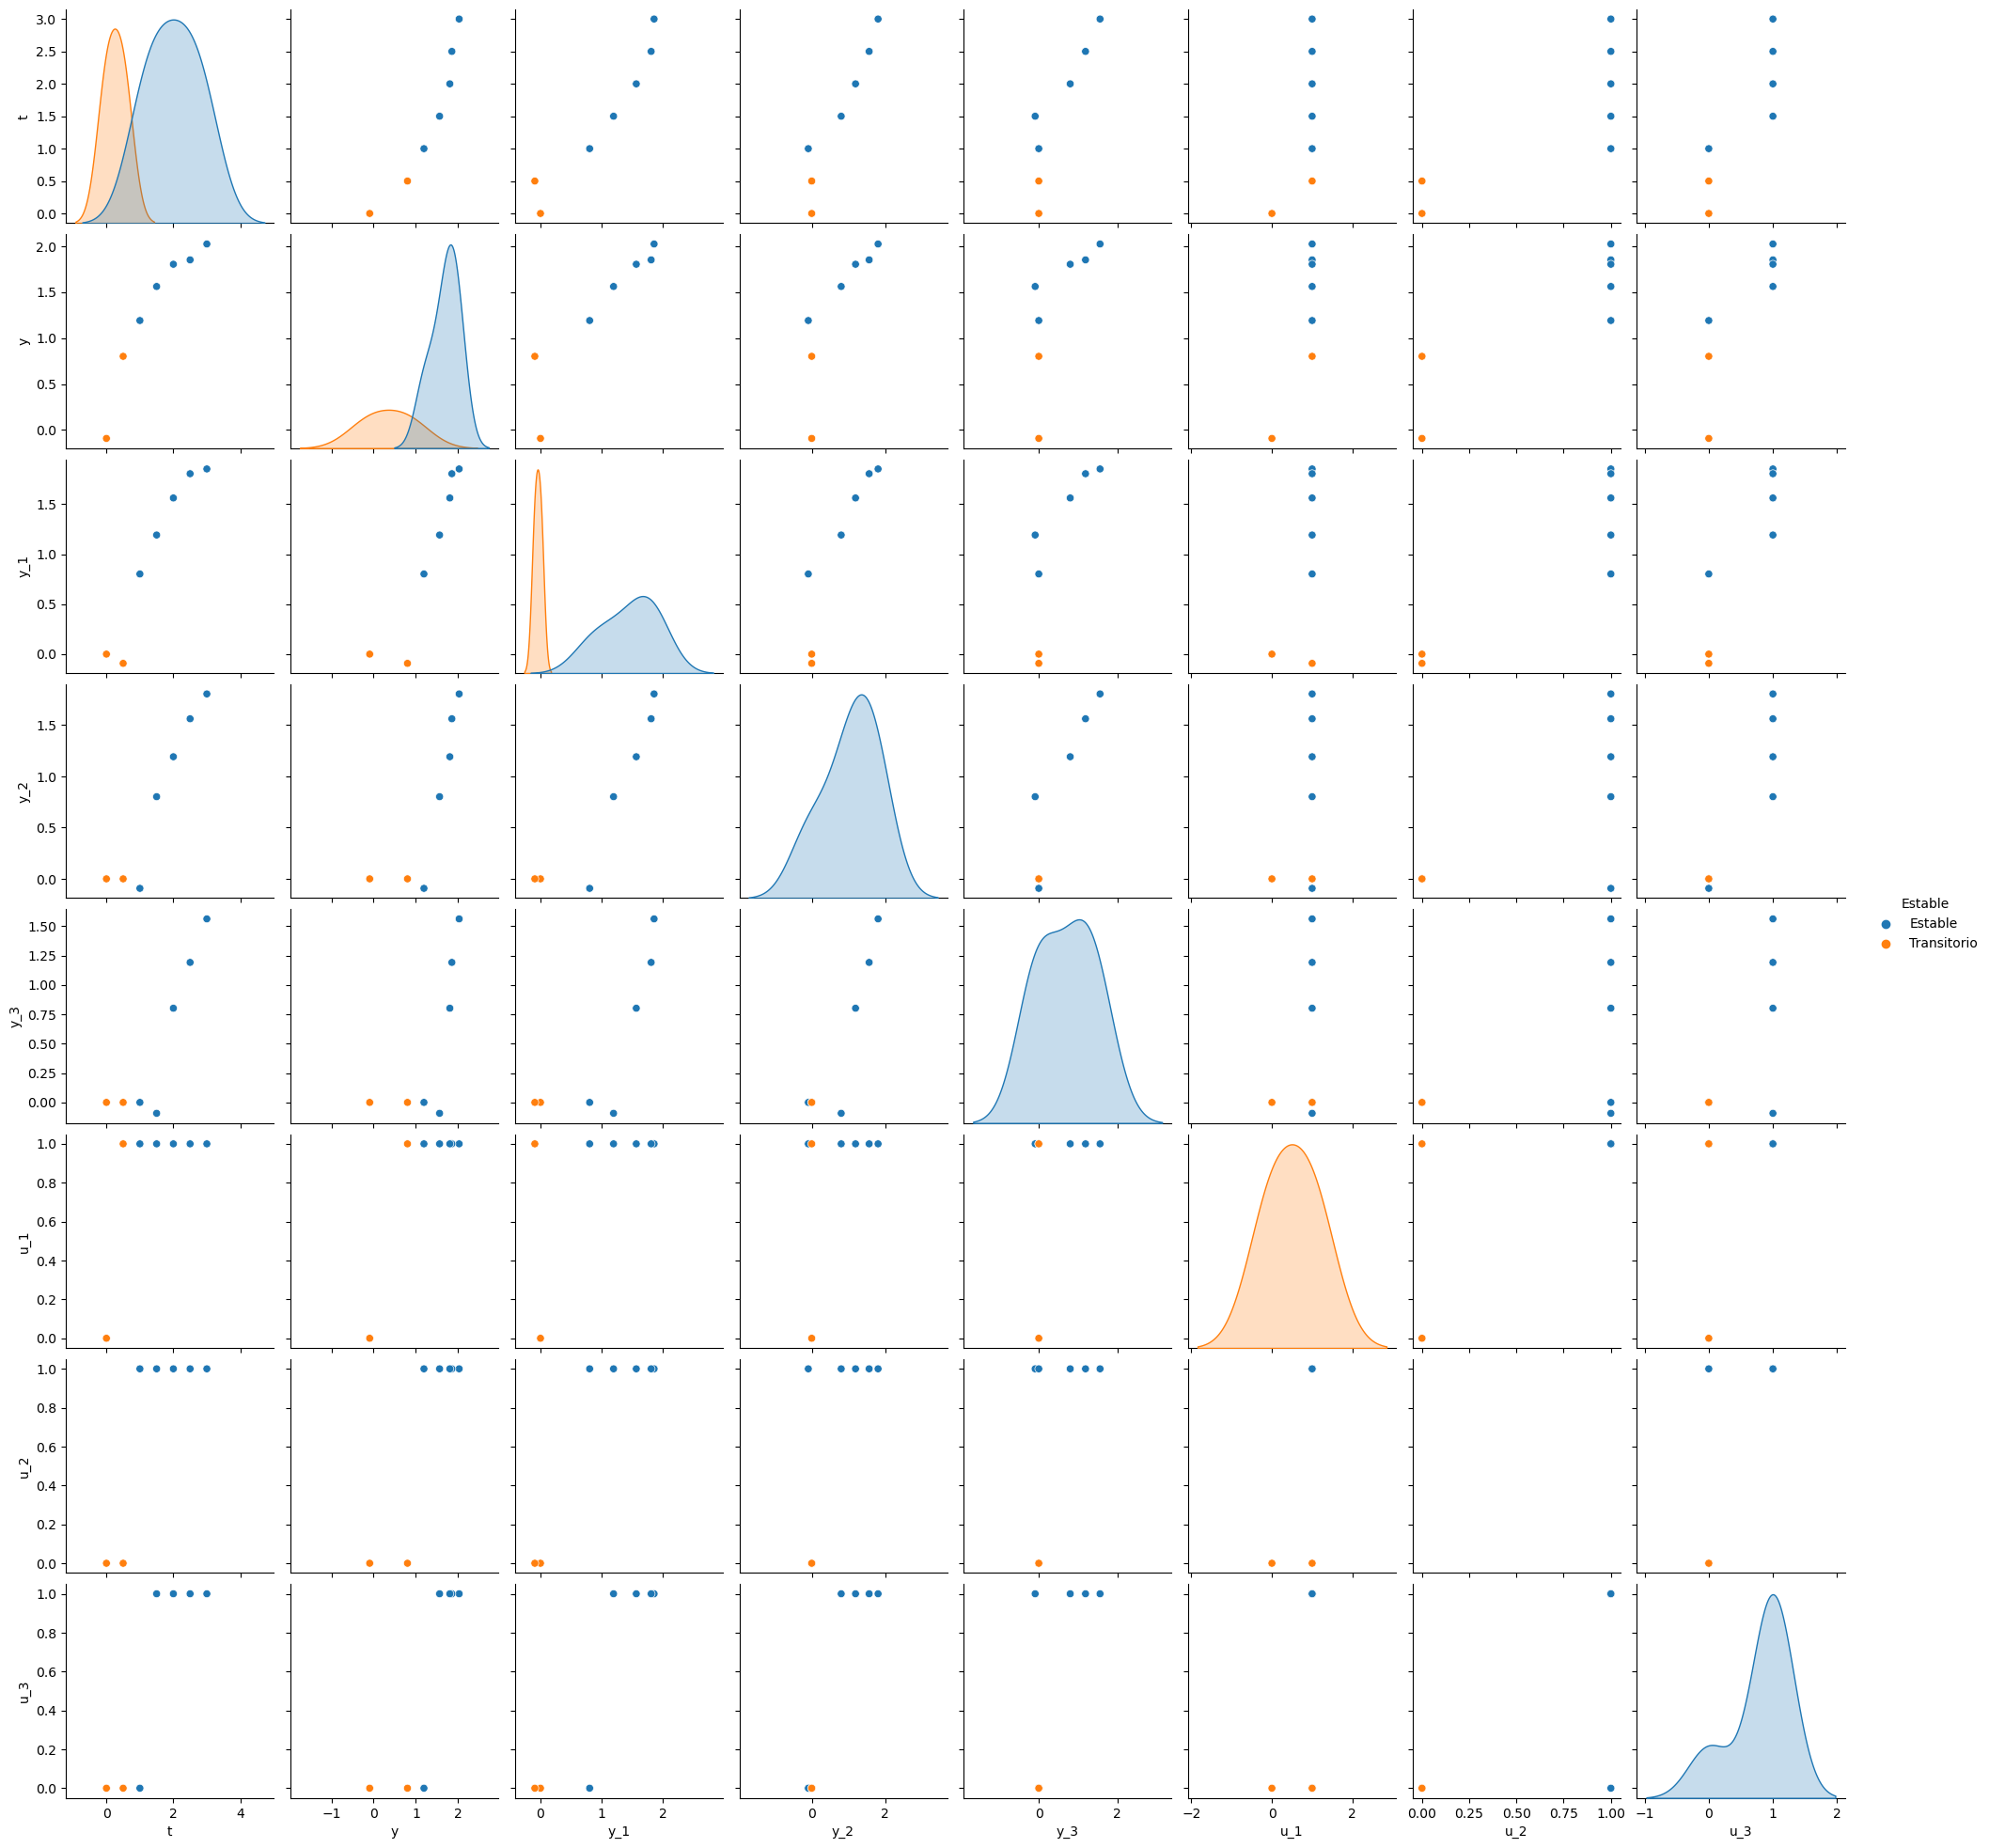

In [14]:
dfRegSample = (dfReg[dfReg['Estable'] == 'Estable'].sample(n=5).
               append(dfReg[dfReg['Estable'] == 'Transitorio'])).reset_index(drop=True)
#sns.pairplot(dfRegSample,hue='Estable')

## Armando la función estimada ARX

**Paso 3:** Definir la función de transferencia estimada $G_e$

In [15]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 
B =  theta[1]*z**-1  

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()

G

## Calculando la respuesta al step de la estimación

**Paso 4:** Calculamos la respuesta de la función $G_e$ y con esos datos determinamos el error de la estimación inicial.

In [16]:
G_e = control.tf([theta[1]],[1,theta[0]],dt)
G_e

TransferFunction(array([0.8348667]), array([ 1.        , -0.57159685]), 0.5)


  0.8349
----------
z - 0.5716

dt = 0.5



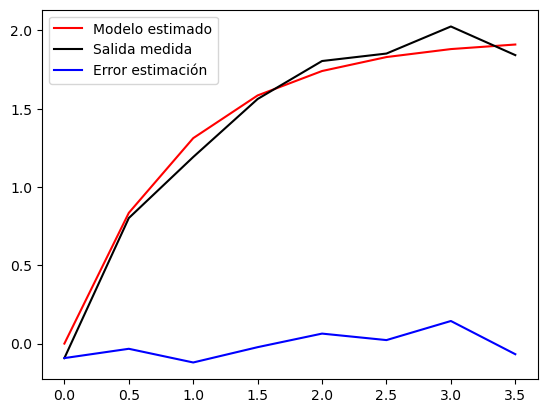

In [17]:
## Definiendo la función de transferencia estimada ARX
_,ye = control.step_response(G_e,t)

## Ganancia de ajuste
k = 1;
ye = k*ye

## Señal de error estimado
e = yn-ye

plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.plot(t,e,color = 'blue')
plt.legend(['Modelo estimado','Salida medida','Error estimación'])

print(G_e)

## Planteando el nuevo regresor

**Paso 5:** Se va propone un nuevo regresor que incluya la señal de error estimada en el paso anterior

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1],u[k-2],u[k-3],e[k-1],e[k-2],e[k-3]]$$

In [18]:
e_1 = np.zeros(N)
e_2 = np.zeros(N)
e_3 = np.zeros(N)

for k in range(1,N):
    e_1[k]=e[k-1]
for k in range(2,N):
    e_2[k]=e[k-2]
for k in range(3,N):
    e_3[k]=e[k-3]
## Creación del vector phi
phi2 = np.array([-y_1,u_1,e_1,e_2,e_3]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

Am = np.dot(phi2.T,phi2) + alpha*np.eye(len(np.dot(phi2.T,phi2)))
theta2 = np.dot(np.linalg.inv(Am),np.dot(phi2.T,yn))
theta2

array([-0.62797462,  0.75706126, -0.71346436,  0.30294866, -0.28162238])

In [19]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A

## Construir los polinomios A(z) y B(z)
A = 1 + theta2[0]*z**-1
B = theta2[1]*z**-1
C = 1 + theta2[2]*z**-1 + theta2[3]*z**-2 + theta2[4]*z**-3 
G = (B/A).simplify()
G

TransferFunction(array([0.75706126]), array([ 1.        , -0.62797462]), 0.5)

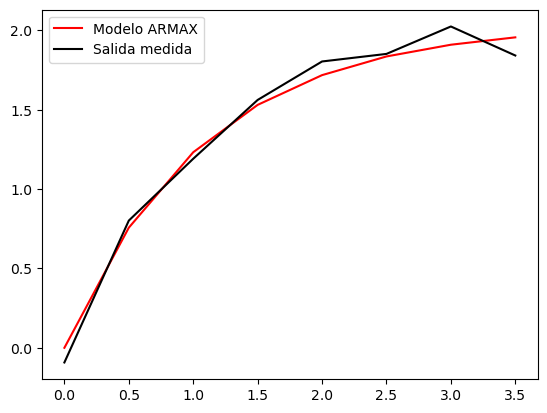

In [20]:
## Armando la función de transferencia estimada con los parámetros hallados
G2 = control.tf([theta2[1]],[1,theta2[0]],dt)

## Se determina la respuesta estimada al escalón
_,y2 = control.step_response(G2,t)

e2 = yn-y2

plt.plot(t,y2,color = 'red')
plt.plot(t,yn,color = 'black')
#plt.plot(t,e2,color = 'green')

plt.legend(['Modelo ARMAX','Salida medida','Error estimacion']);
G2

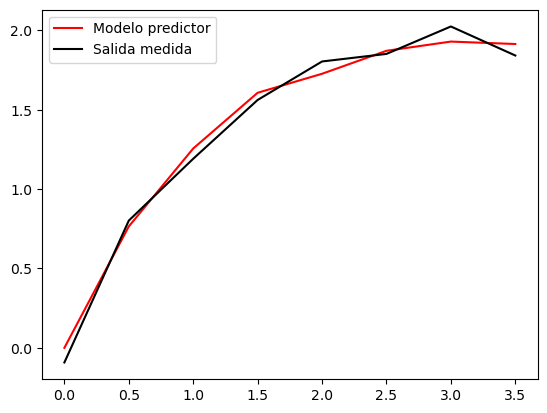

In [22]:
## Armando la función estimada con los parámetros hallados y usando el predictor.

yf = (-theta2[0]*y_1 + 
      theta2[1]*u_1 + 
      (theta2[2]*e_1+theta2[3]*e_2+theta2[4]*e_3)  )
plt.plot(t,yf,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo predictor','Salida medida'])